# UCI HAR - classification
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

#### 데이터 종류
- 561개 특성으로 전처리된 메인 데이터셋(X_train, X_test)
- Inertial Signals 데이터셋: 원시 센서 값(raw signal)

#### Inertial Signals 데이터 구조
- 각 파일은 행 = 샘플(segment), 열 = 시계열 프레임을 의미
- 각 샘플은 2.56초 길이 (샘플링 주파수 50Hz, 128 타임스텝 → 128 / 50 = 2.56초)
- 이미 샘플링이 되어 있으므로(7352개의 샘플) split_sequence() 사용하지 않아도 됨
- 한 행이 (128,) 길이의 시계열 벡터
- 세 축(X, Y, Z)와 센서 종류(acc, gyro)로 분리되어 있음

#### 센서 및 값의 의미
- Total acceleration (total_acc): 스마트폰 가속도계로 측정한 총 가속도 (중력 + 신체 움직임 포함)
- Body acceleration (body_acc): 총 가속도에서 중력 성분을 제거한 값 (실제 동작 가속도)
- Gyroscope (body_gyro): 각속도(회전 속도), 단위는 rad/sec, 스마트폰의 자이로스코프 센서 값

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [ ]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_data/UCI HAR Dataset/"

# Load "X"
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []  # 한 센서축 데이터 전체 저장

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])


X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


In [ ]:
# Load "y"

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # 라벨을 0부터 시작하도록 -1 (원래 라벨이 1부터 시)
    return np.array(labels, dtype=np.int32) - 1


y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train[:5])

y_train shape: (7352,)
y_test shape: (2947,)
[4 4 4 4 4]


# Transfomer
### 1. 하이퍼파라미터
d_model: 임베딩 차원
- 원 논문에서는 512, UCI HAR은 데이터 크기와 복잡성이 훨씬 작기 때문에 더 작은 크기로 설정

num_heads: 멀티헤드 수

ff_dim: FFN 내부 차원

num_layers: 인코더 블록의 층 개수

max_len: 위치 인코딩을 미리 만들어둘 최대 시퀀스 길이
- UCI HAR은 128로 윈도우가 고정이므로 128로 설정 (더 많이 만들어 둘 필요 없음)

### 2. Positional Encoding
[:, tf.newaxis]로 차원을 추가하는 이유
- 위치, 차원 곱셈을 통해 (L, D)로 브로드캐스팅하기 위해서

Positional Encoding 공식
- angle = pos / (10000^(2k/d_model))
- pos = 위치(시간) 인덱스 = 0,1,2,…,L-1
- d=d_model
- k=⌊i/2⌋ (채널 인덱스 i를 짝수/홀수 쌍으로 묶기 위해)

angle_rates
- 각 채널마다 다른 스케일 값을 가지고 있는 1행짜리 행렬
- (L,1) 모양의 position과 곱하면 (L,D)로 브로드캐스팅돼서 모든 위치×채널 조합의 각도가 만들어진다.

pe = tf.reshape(tf.stack([sines, coses], axis=-1), (max_len, -1))
- tf.stack(): 짝수/홀수 값이 페어로 묶임 -> (L, D/2, 2)
- e.g.
```
sines = [[s0, s2, s4], ...]
coses = [[c1, c3, c5], ...]
stack = [[[s0, c1],
           [s2, c3],
           [s4, c5]]. ...]
         

- (max_len, -1): 다시 (L, D)로 reshape
- e.g.


```
[[s0,c1,s2,c3,s4,c5], ...]
```



pe[:, :d_model][tf.newaxis, ...]
- batch 차원을 앞에 더해준다.


### 3. Transformer Encoder Block
Pre-LN을 사용하는 이유
- Pre-LN은 정규화한 값을 레이어에 입력 -> 안정적
- 잔차가 그대로 유지됨 -> gradient 흐름이 원활
- 반면 Post-LN은 잔차가 정규화되므로 층이 깊어질 수록 그래디언트 소실/폭발 위험

key-dim
- 헤드 당 차원

(h, h)
- Query, Value 값. 내부에서 key=value로 자동 복사

## Model 1
- 인코더 레이어 1개 (num_layers = 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention

# 1. 하이퍼파라미터
num_classes = 6
d_model     = 128
num_heads   = 4
ff_dim      = 256
num_layers  = 1
drop_rate   = 0.2
max_len     = 128

# 2. Positional Encoding
class SinePositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len=128, d_model=128, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.d_model = d_model

        # 위치 인덱스, 채널(d_model) 인덱스 생성
        position = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]  # (L, 1)
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]         # (1, D)

        # 공식: angle = pos / (10000^(2k/d_model))
        angle_rates = tf.pow(10000.0, -(tf.floor(i/2) * 2) / tf.cast(d_model, tf.float32))  # (1, D)
        angles = position * angle_rates # (L, D)

        # 짝수 채널에는 sin, 홀수 채널에는 cos을 적용
        sines = tf.sin(angles[:, 0::2])  # (L, D/2)
        coses = tf.cos(angles[:, 1::2])  # (L, D/2)

        # sin과 cos 채널을 다시 합침
        pe = tf.reshape(tf.stack([sines, coses], axis=-1), (max_len, -1))
        self.pe = pe[:, :d_model][tf.newaxis, ...]

    def call(self, x, training=None, mask=None): # 고정된 시퀀스 길이(128), 패딩 마스크 안 써도 됨
        # x: (B, T, D). 현재 배치의 T 길이에 맞춰 위치 인코딩을 잘라 더한다.
        T = tf.shape(x)[1]
        return x + self.pe[:, :T, :]  # (B, T, D)  ← 위치 정보가 더해진 결과


# Transformer Encoder Block (Pre-LN)
def transformer_encoder_block(x, d_model, num_heads, ff_dim, drop):
    h = LayerNormalization(epsilon=1e-6)(x) # epsilon: 분모가 0이 되는 것을 막음
    h = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads, dropout=drop)(h, h)
    h = Dropout(drop)(h)
    x = x + h # Residual Connection

    h = LayerNormalization(epsilon=1e-6)(x)
    h = Dense(ff_dim, activation='relu')(h)
    h = Dropout(drop)(h)
    h = Dense(d_model)(h)
    h = Dropout(drop)(h)
    return x + h

# 모델 구성 (input_shape: (128, 9))
def build_har_transformer(
    input_timesteps=128,
    n_features=9,
    num_classes=6,
    d_model=128,
    num_heads=4,
    ff_dim=256,
    num_layers=1,
    drop_rate=0.2,
    max_len=128,
    classifier_hidden_dim=128, # 최종 분류기 은닉층 차원
    classifier_drop_rate=0.3, # 최종 분류기 dropout rate
):
    inp = Input(shape=(input_timesteps, n_features))

    # Input embedding - 입력 차원 맞추기
    x = Dense(d_model)(inp)

    # Positional Encoding
    x = SinePositionalEncoding(max_len=max_len, d_model=d_model)(x)

    # Transformer Encoder 스택
    for _ in range(num_layers):
        x = transformer_encoder_block(x, d_model, num_heads, ff_dim, drop_rate)

    # 시퀀스 풀링(B, d_model) - dense layer에 넣을 수 있게끔
    x = GlobalAveragePooling1D()(x)

    # 분류기
    x = Dense(classifier_hidden_dim, activation='relu')(x)
    x = Dropout(classifier_drop_rate)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_har_transformer(input_timesteps=128, n_features=9)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128, 128)  │      1,280 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_positional_en… │ (None, 128, 128)  │          0 │ dense_27[0][0]    │
│ (SinePositionalEnc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ sine_positional_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 128, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 128, 128)  │          0 │ sine_positional_… │
│                     │                   │            │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 128, 256)  │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 128, 128)  │     32,896 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 128, 128)  │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 128, 128)  │          0 │ add_12[0][0],     │
│                     │                   │            │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_13[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 128)       │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 6)         │        774 │ dropout_33[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 151,046 (590.02 KB)

 Trainable params: 151,046 (590.02 KB)

 Non-trainable params: 0 (0.00 B)

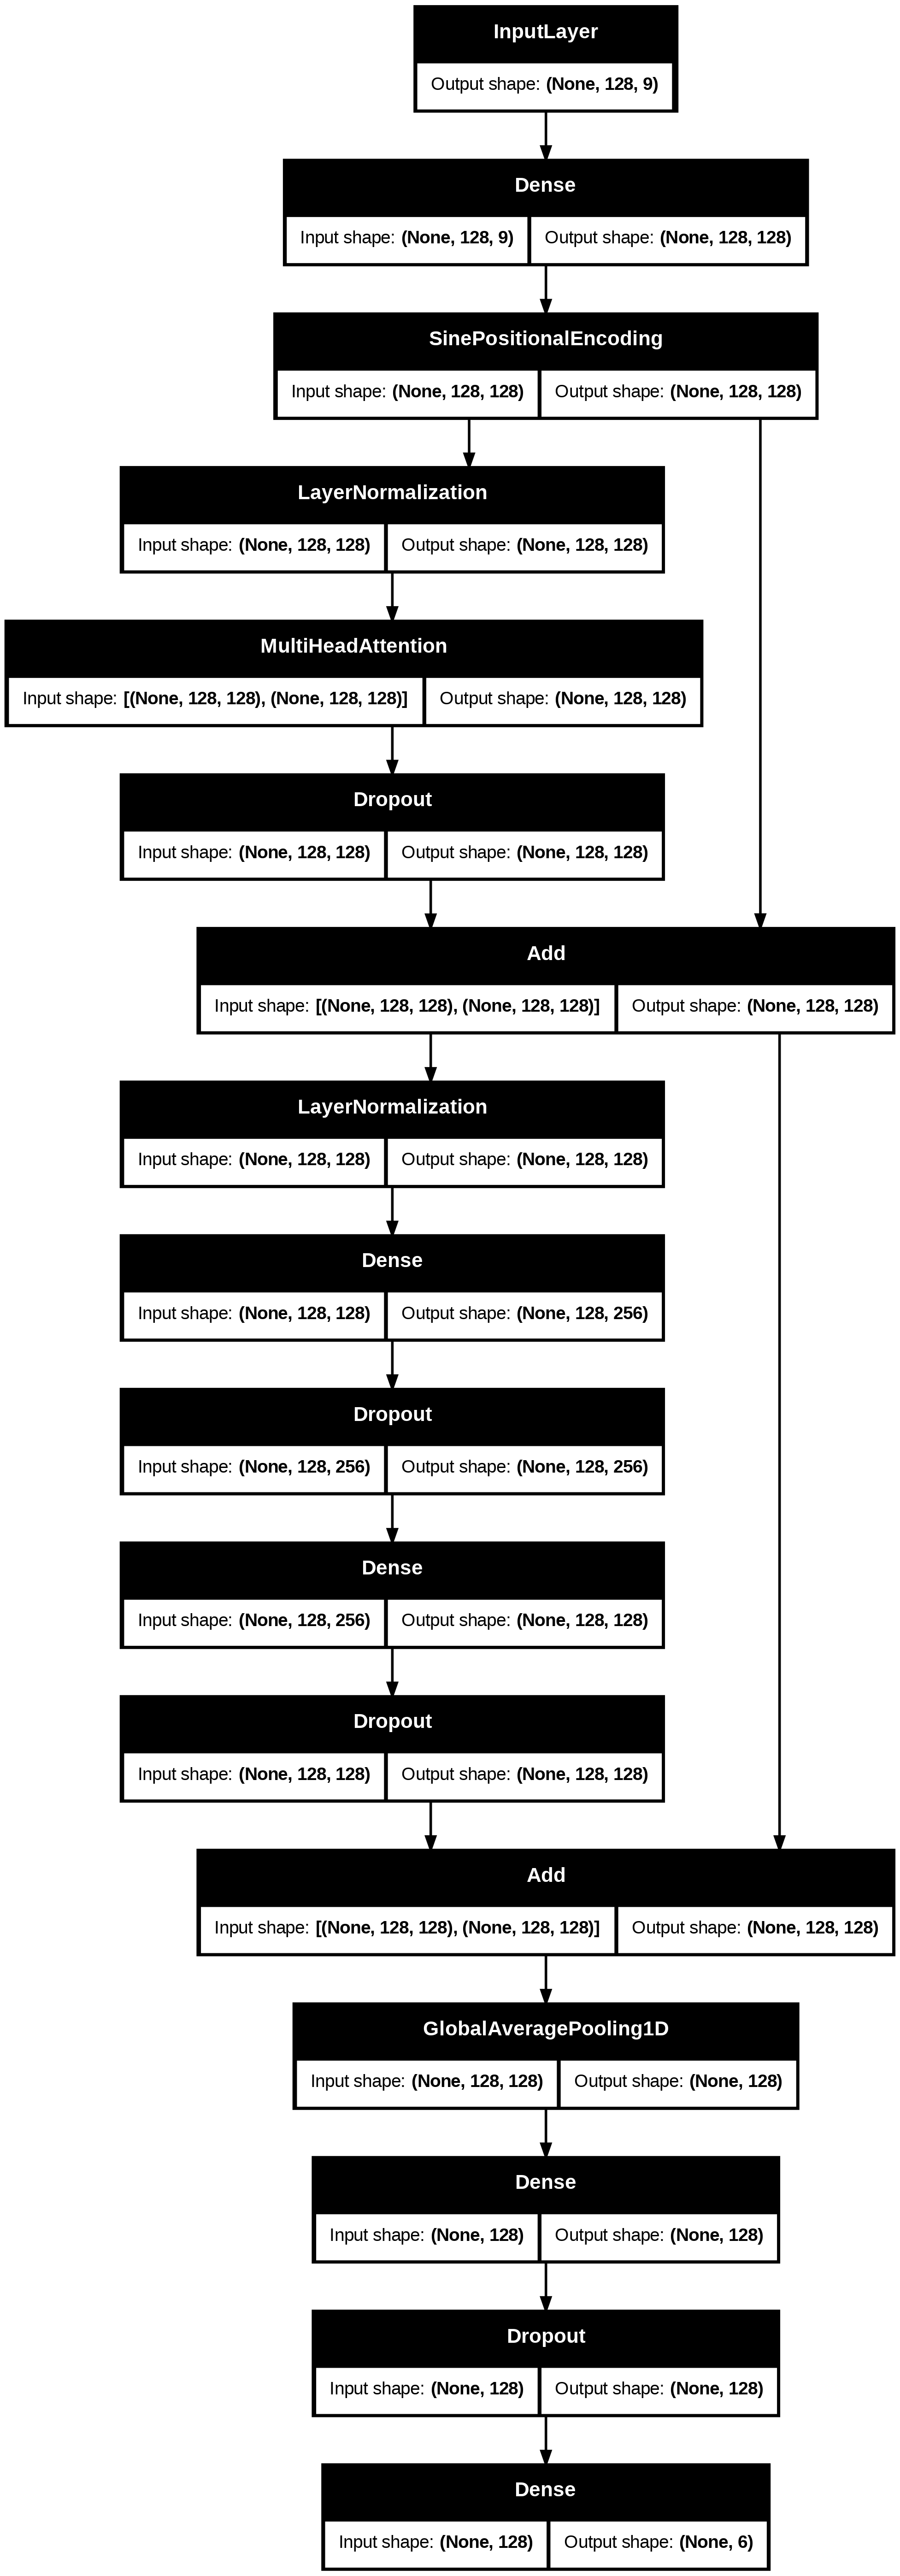

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_Transformer_best.weights.h5",
                save_best_only=True,
                save_weights_only=True, # 모델을 저장하면 Positional Encoding 레이어 생성 시 too many positioanl argument 에러가 나서 가중치만 저
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.4129 - sparse_categorical_accuracy: 0.3984
Epoch 1: val_loss improved from inf to 0.53184, saving model to UCI_HAR_Transformer_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 1.4093 - sparse_categorical_accuracy: 0.3998 - val_loss: 0.5318 - val_sparse_categorical_accuracy: 0.7587
Epoch 2/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5367 - sparse_categorical_accuracy: 0.7692
Epoch 2: val_loss improved from 0.53184 to 0.29328, saving model to UCI_HAR_Transformer_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5352 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.2933 - val_sparse_categorical_accuracy: 0.8865
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3247 - sparse_categorical_accuracy: 0.8736
Epoch 3: val_loss improved from 0.29328 to 0.23490, saving model to UCI_HAR_Transformer_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3245 - sparse_catego

In [ ]:
# 평가에 사용할 모델 로드
def load_best_model():
    model = build_har_transformer(input_timesteps=128, n_features=9)
    # 최고 성능 가중치 로드
    model.load_weights("UCI_HAR_Transformer_best.weights.h5")
    return model

In [ ]:
# 모델 평가
model = load_best_model()

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 93.43%
Training loss: 0.1772
Test accuracy: 85.61%
Test loss: 0.6320


model.predict
- 각 시퀀스 샘플마다, 모든 클래스에 대한 예측 확률 벡터
- y_pred_proba.shape -> (샘플 수, 클래스 수)

np.argmax
- 최대 값의 인덱스를 선택 = 라벨

In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8260    0.7944    0.8099       496
           1     0.9769    0.7197    0.8289       471
           2     0.7170    0.9714    0.8251       420
           3     0.8718    0.7617    0.8130       491
           4     0.8010    0.8853    0.8411       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.8561      2947
   macro avg     0.8655    0.8554    0.8530      2947
weighted avg     0.8694    0.8561    0.8559      2947



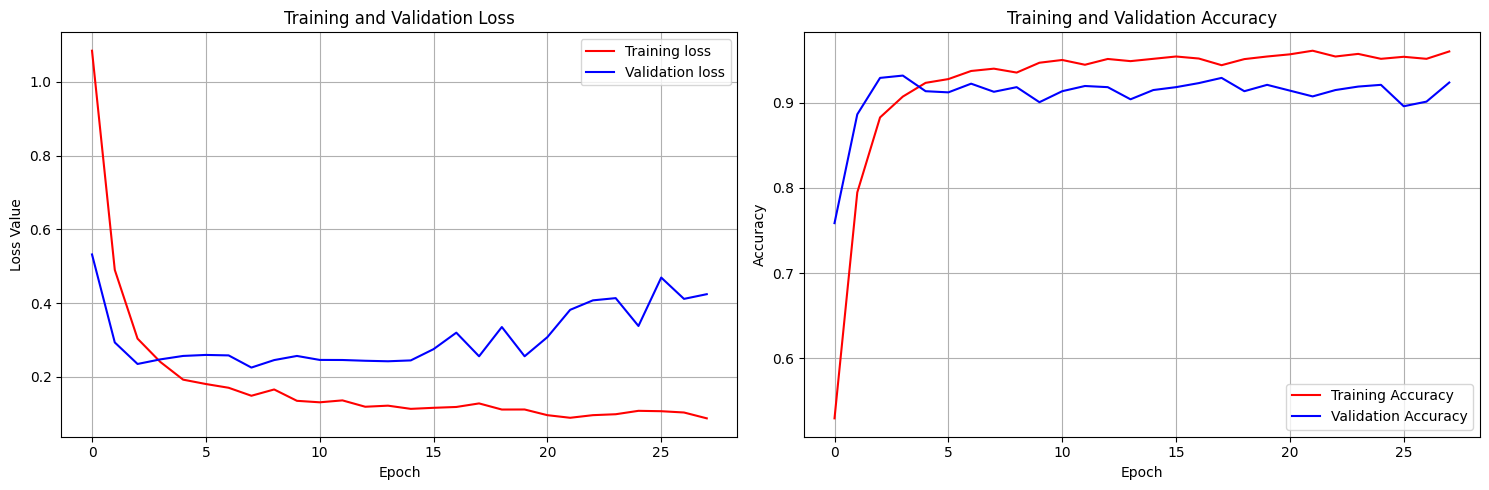

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

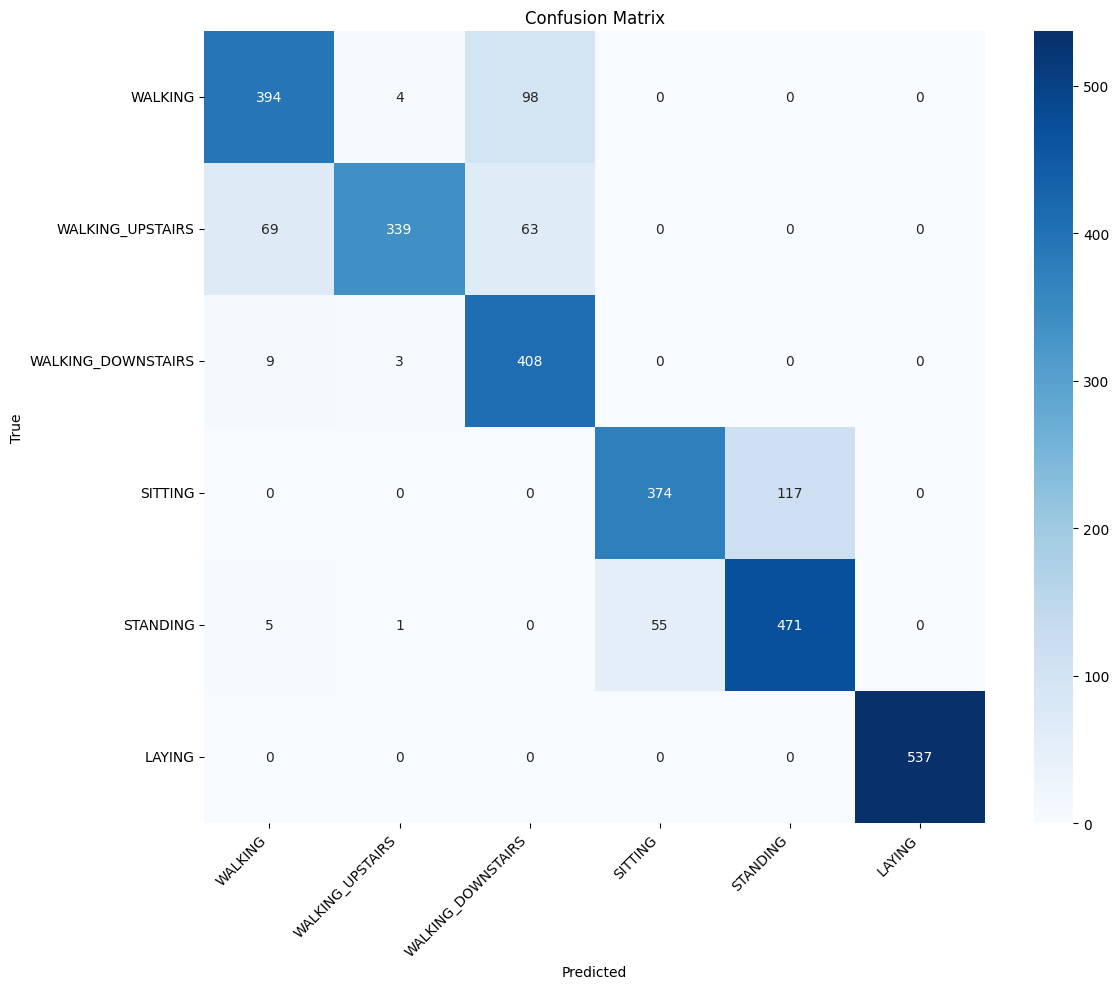

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- 인코더 레이어 2개

In [ ]:
model = build_har_transformer(input_timesteps=128, n_features=9, num_layers=2)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 128, 128)  │      1,280 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_positional_en… │ (None, 128, 128)  │          0 │ dense_51[0][0]    │
│ (SinePositionalEnc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ sine_positional_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 128, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 128, 128)  │          0 │ sine_positional_… │
│                     │                   │            │ dropout_58[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 128, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 128, 256)  │          0 │ dense_52[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 128, 128)  │     32,896 │ dropout_59[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_60          │ (None, 128, 128)  │          0 │ dense_53[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 128, 128)  │          0 │ add_24[0][0],     │
│                     │                   │            │ dropout_60[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 128, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 128, 128)  │          0 │ add_25[0][0],     │
│                     │                   │            │ dropout_62[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_26[0][0]    

 Total params: 283,526 (1.08 MB)

 Trainable params: 283,526 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

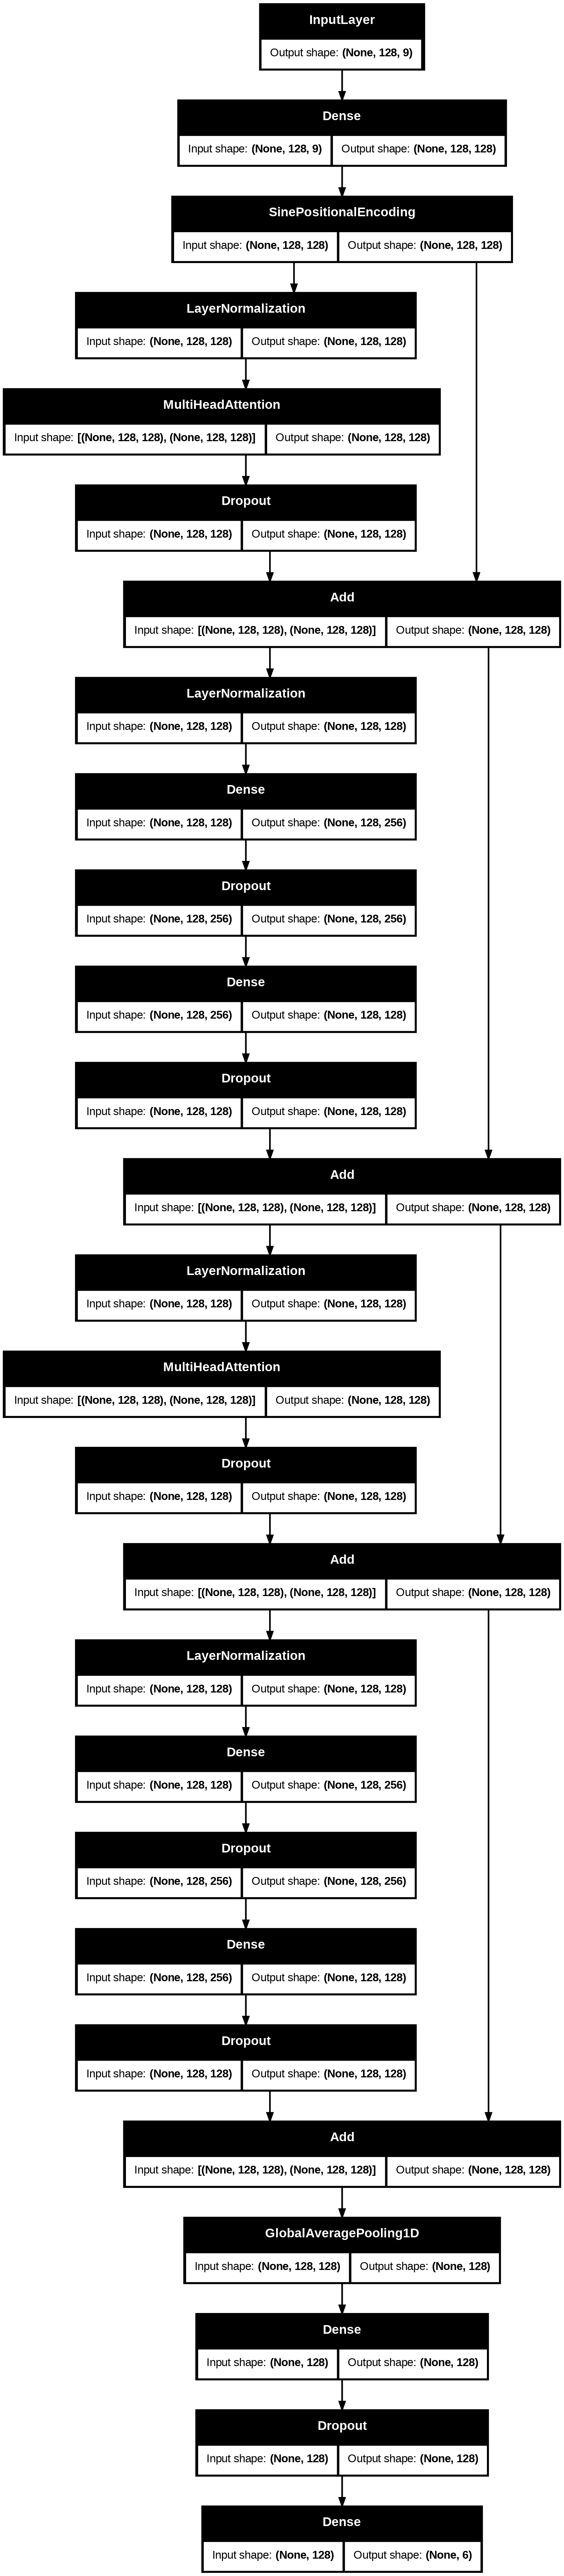

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_Transformer_best2.weights.h5",
                save_best_only=True,
                save_weights_only=True, # 모델을 저장하면 Positional Encoding 레이어 생성 시 too many positioanl argument 에러가 나서 가중치만 저장
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )


Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.3630 - sparse_categorical_accuracy: 0.4217
Epoch 1: val_loss improved from inf to 0.39765, saving model to UCI_HAR_Transformer_best2.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - loss: 1.3595 - sparse_categorical_accuracy: 0.4231 - val_loss: 0.3976 - val_sparse_categorical_accuracy: 0.8416
Epoch 2/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4809 - sparse_categorical_accuracy: 0.7940
Epoch 2: val_loss improved from 0.39765 to 0.22582, saving model to UCI_HAR_Transformer_best2.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4788 - sparse_categorical_accuracy: 0.7951 - val_loss: 0.2258 - val_sparse_categorical_accuracy: 0.9334
Epoch 3/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2873 - sparse_categorical_accuracy: 0.8864
Epoch 3: val_loss did not improve from 0.22582
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2860 - sparse_categorical_accuracy: 0.8871 - val_loss: 0.2471 - val_spa

In [ ]:
# 평가에 사용할 모델 로드
def load_best_model():
    model = build_har_transformer(input_timesteps=128, n_features=9, num_layers=2)
    # 최고 성능 가중치 로드
    model.load_weights("UCI_HAR_Transformer_best2.weights.h5")
    return model

In [ ]:
# 모델 평가
model = load_best_model()

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 95.31%
Training loss: 0.1218
Test accuracy: 87.65%
Test loss: 0.5400


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8855    0.8105    0.8463       496
           1     0.9222    0.8811    0.9012       471
           2     0.8227    0.9500    0.8818       420
           3     0.7768    0.8574    0.8151       491
           4     0.8539    0.7688    0.8091       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.8765      2947
   macro avg     0.8768    0.8780    0.8756      2947
weighted avg     0.8794    0.8765    0.8762      2947



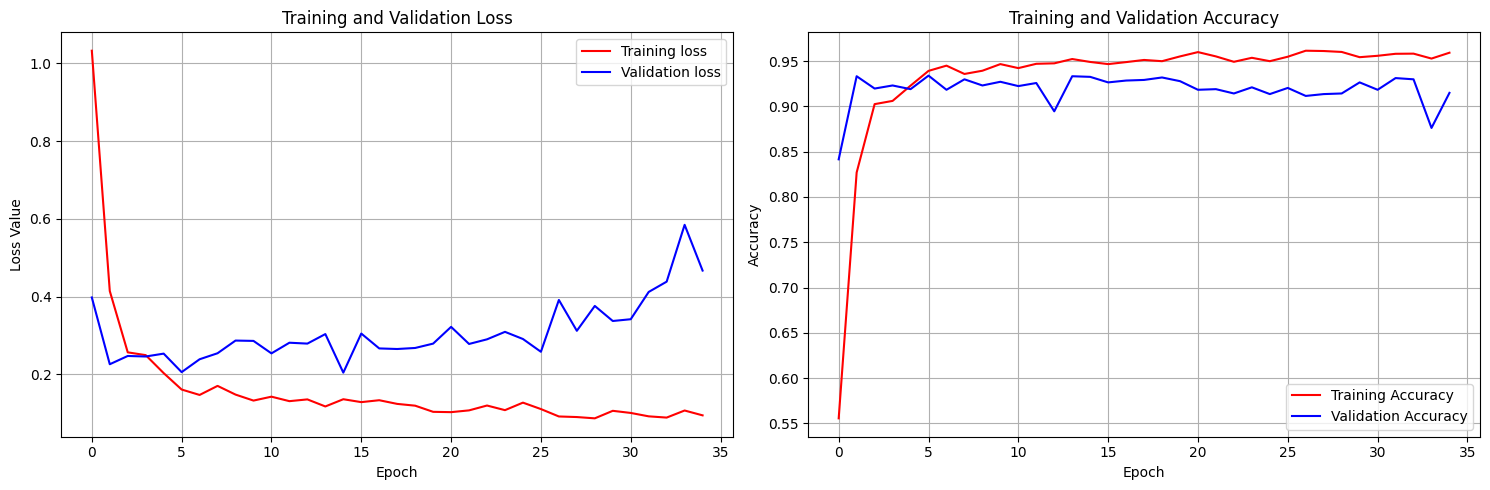

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

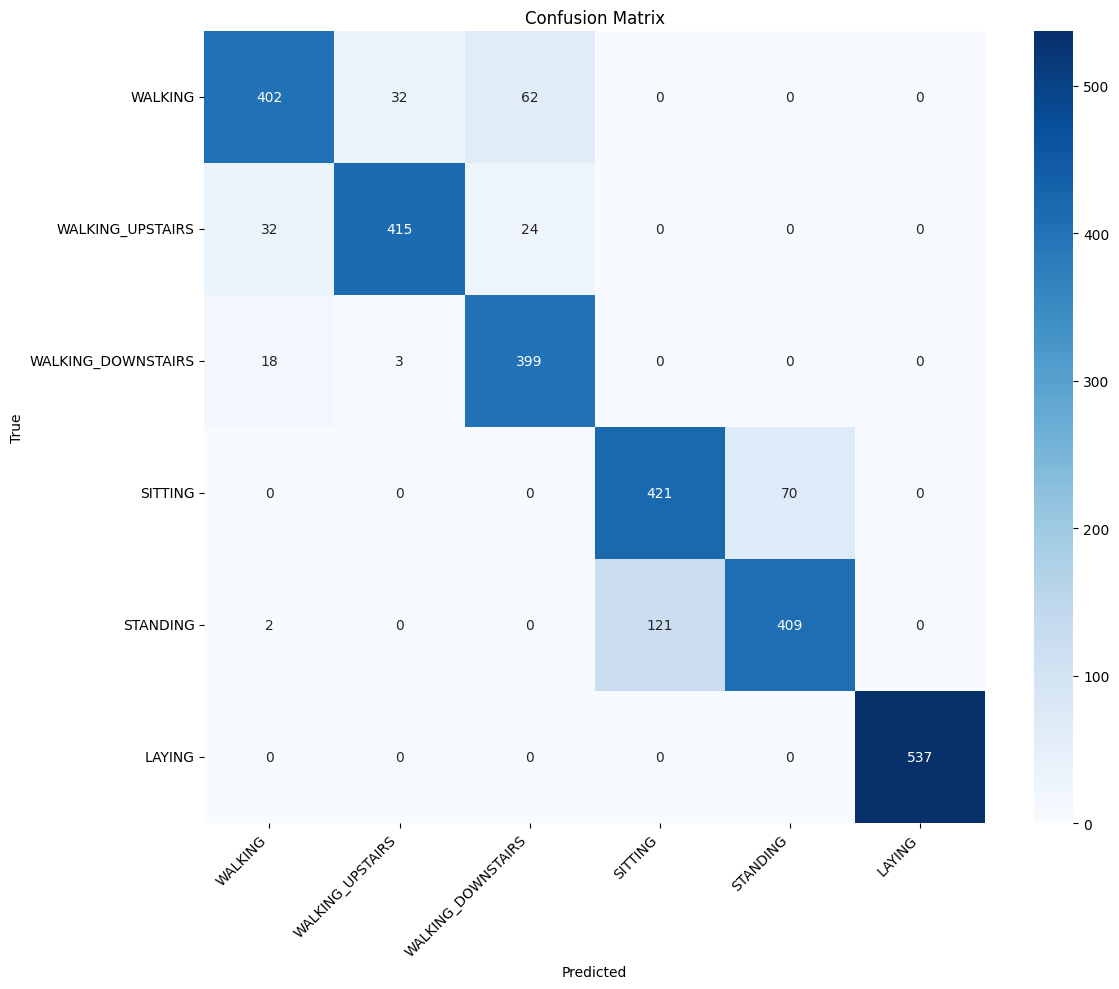

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 3
- 인코더 레이어 3개

In [ ]:
model = build_har_transformer(input_timesteps=128, n_features=9, num_layers=3)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 128, 128)  │      1,280 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_positional_en… │ (None, 128, 128)  │          0 │ dense_58[0][0]    │
│ (SinePositionalEnc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ sine_positional_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 128, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 128, 128)  │          0 │ sine_positional_… │
│                     │                   │            │ dropout_67[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_28[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 128, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 128, 256)  │          0 │ dense_59[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 128, 128)  │     32,896 │ dropout_68[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_69          │ (None, 128, 128)  │          0 │ dense_60[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 128, 128)  │          0 │ add_28[0][0],     │
│                     │                   │            │ dropout_69[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_29[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 128, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 128, 128)  │          0 │ add_29[0][0],     │
│                     │                   │            │ dropout_71[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_30[0][0]    

 Total params: 416,006 (1.59 MB)

 Trainable params: 416,006 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

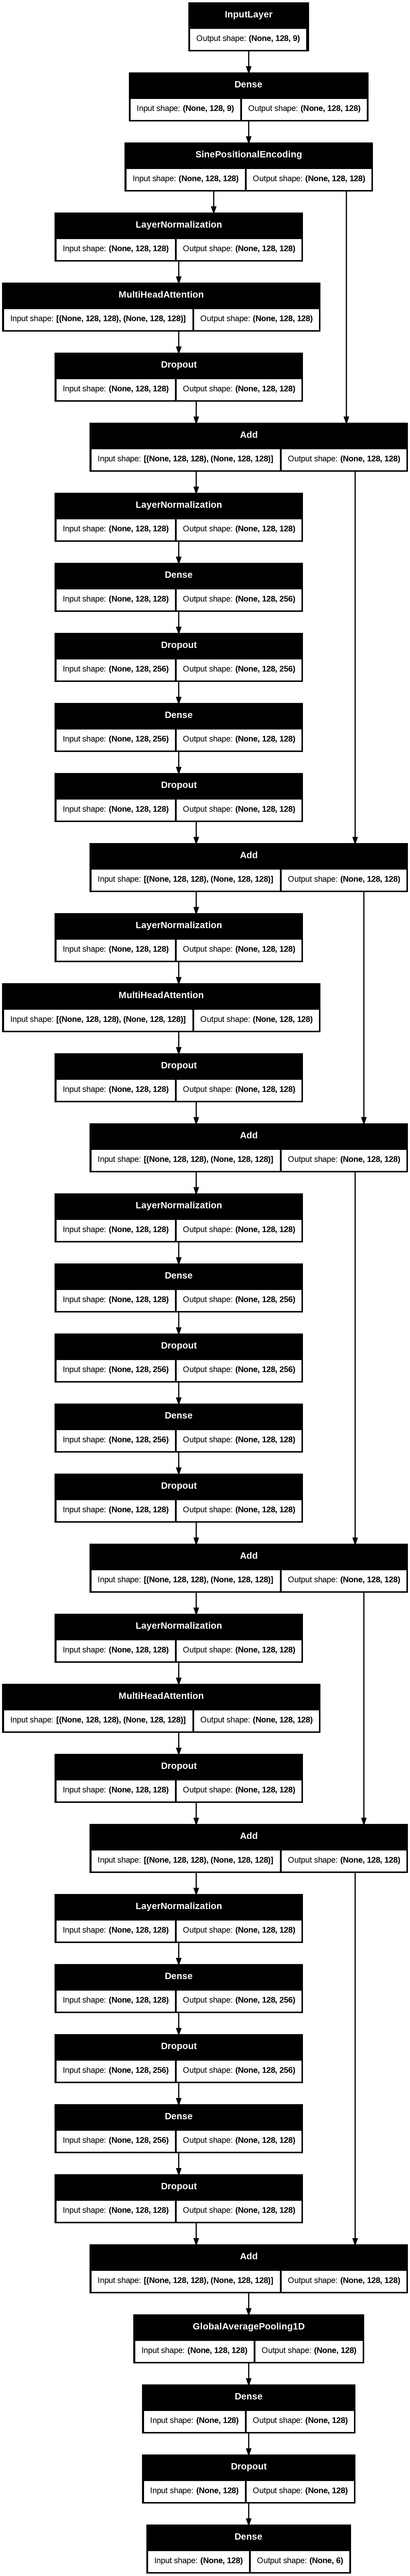

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_Transformer_best3.weights.h5",
                save_best_only=True,
                save_weights_only=True, # 모델을 저장하면 Positional Encoding 레이어 생성 시 too many positioanl argument 에러가 나서 가중치만 저장
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5626 - sparse_categorical_accuracy: 0.7639
Epoch 1: val_loss improved from inf to 0.33327, saving model to UCI_HAR_Transformer_best3.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.5602 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.3333 - val_sparse_categorical_accuracy: 0.8783
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3820 - sparse_categorical_accuracy: 0.8467
Epoch 2: val_loss improved from 0.33327 to 0.26994, saving model to UCI_HAR_Transformer_best3.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.3817 - sparse_categorical_accuracy: 0.8468 - val_loss: 0.2699 - val_sparse_categorical_accuracy: 0.9103
Epoch 3/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2484 - sparse_categorical_accuracy: 0.9071
Epoch 3: val_loss did not improve from 0.26994
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2483 - sparse_categorical_accuracy: 0.9071 - val_loss: 0.3264 - val_sparse

In [ ]:
# 평가에 사용할 모델 로드
def load_best_model():
    model = build_har_transformer(input_timesteps=128, n_features=9, num_layers=3)
    # 최고 성능 가중치 로드
    model.load_weights("UCI_HAR_Transformer_best3.weights.h5")
    return model

In [ ]:
# 모델 평가
model = load_best_model()

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 110 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 93.23%
Training loss: 0.1674
Test accuracy: 86.36%
Test loss: 0.4427


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8052    0.8669    0.8350       496
           1     0.9426    0.7665    0.8454       471
           2     0.8284    0.9310    0.8767       420
           3     0.8217    0.7699    0.7950       491
           4     0.8055    0.8797    0.8410       532
           5     1.0000    0.9628    0.9810       537

    accuracy                         0.8636      2947
   macro avg     0.8672    0.8628    0.8623      2947
weighted avg     0.8688    0.8636    0.8636      2947



- overfitting

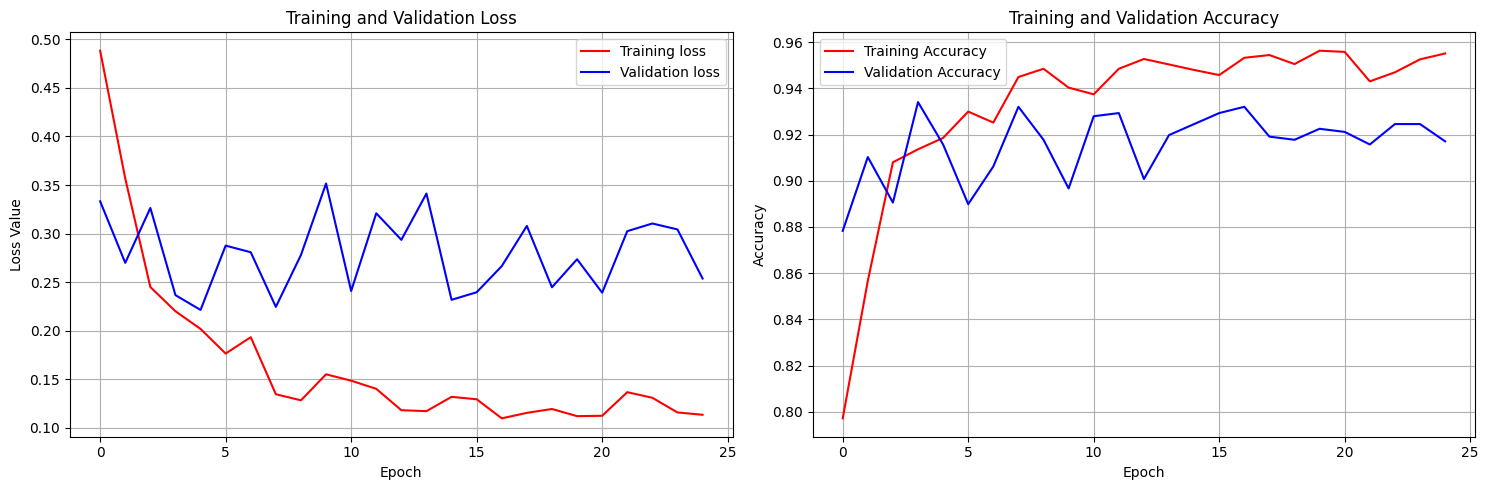

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

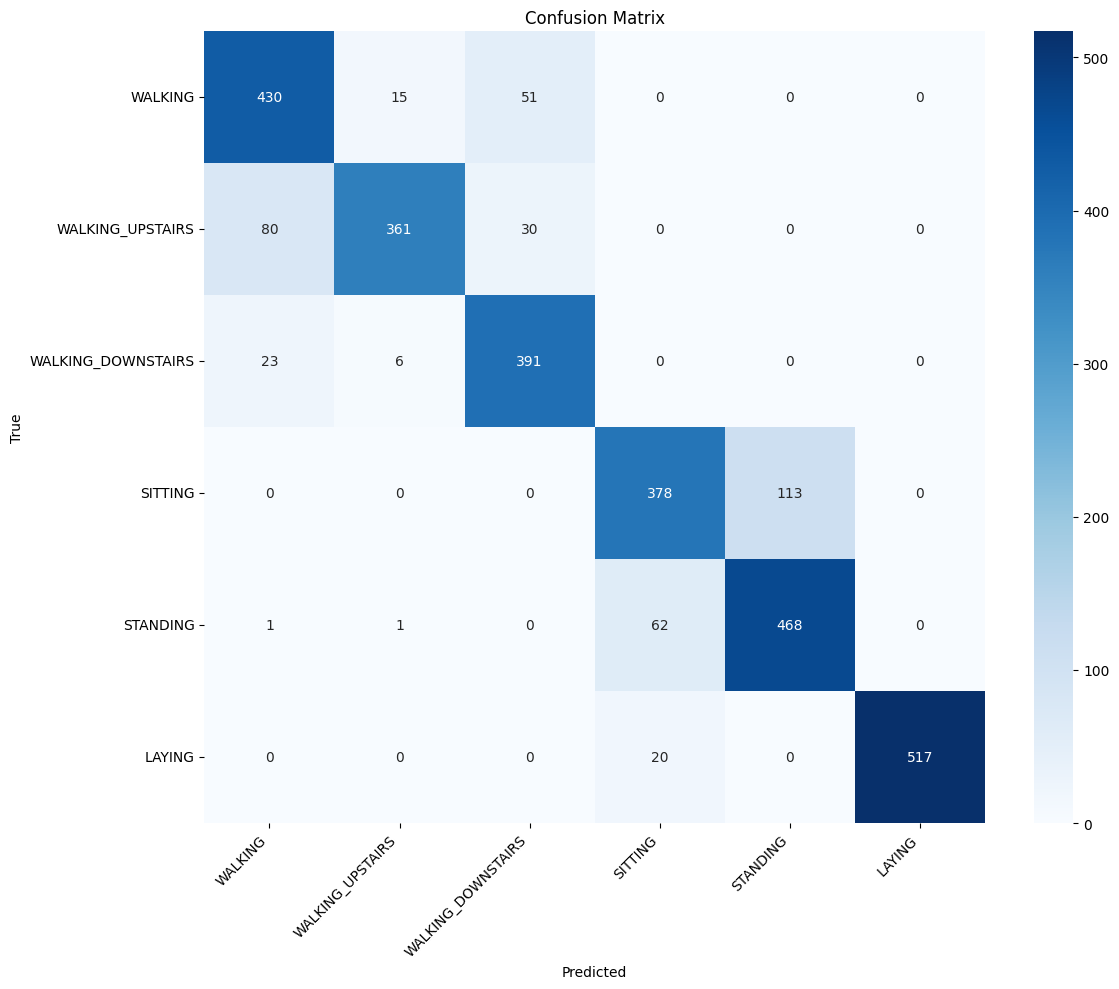

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 4
- 인코더 레이어 2개, head 8개

In [ ]:
model = build_har_transformer(input_timesteps=128, n_features=9, num_layers=2, num_heads=8)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 128, 128)  │      1,280 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_positional_en… │ (None, 128, 128)  │          0 │ dense_83[0][0]    │
│ (SinePositionalEnc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ sine_positional_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_102         │ (None, 128, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 128, 128)  │          0 │ sine_positional_… │
│                     │                   │            │ dropout_102[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_44[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 128, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_103         │ (None, 128, 256)  │          0 │ dense_84[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 128, 128)  │     32,896 │ dropout_103[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_104         │ (None, 128, 128)  │          0 │ dense_85[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 128, 128)  │          0 │ add_44[0][0],     │
│                     │                   │            │ dropout_104[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_45[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_106         │ (None, 128, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_46 (Add)        │ (None, 128, 128)  │          0 │ add_45[0][0],     │
│                     │                   │            │ dropout_106[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_46[0][0]    

 Total params: 283,526 (1.08 MB)

 Trainable params: 283,526 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

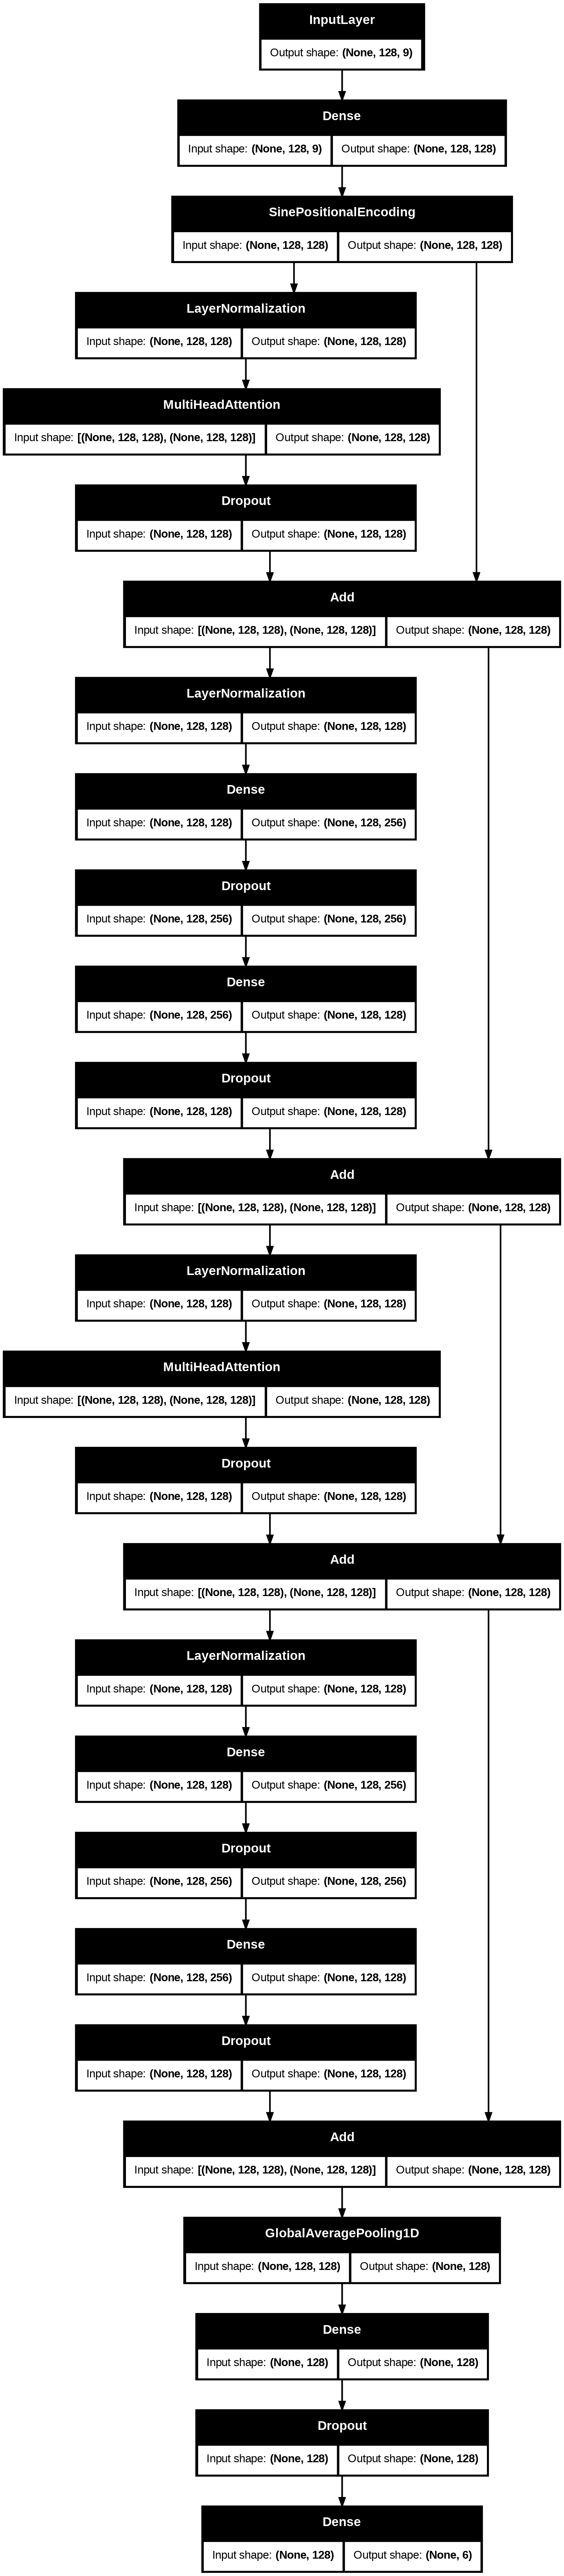

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_Transformer_best4.weights.h5",
                save_best_only=True,
                save_weights_only=True, # 모델을 저장하면 Positional Encoding 레이어 생성 시 too many positioanl argument 에러가 나서 가중치만 저장
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 1.4060 - sparse_categorical_accuracy: 0.4200
Epoch 1: val_loss improved from inf to 0.64193, saving model to UCI_HAR_Transformer_best4.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - loss: 1.4032 - sparse_categorical_accuracy: 0.4209 - val_loss: 0.6419 - val_sparse_categorical_accuracy: 0.7077
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6979 - sparse_categorical_accuracy: 0.6937
Epoch 2: val_loss improved from 0.64193 to 0.43768, saving model to UCI_HAR_Transformer_best4.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6970 - sparse_categorical_accuracy: 0.6942 - val_loss: 0.4377 - val_sparse_categorical_accuracy: 0.8226
Epoch 3/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3892 - sparse_categorical_accuracy: 0.8516
Epoch 3: val_loss improved from 0.43768 to 0.28666, saving model to UCI_HAR_Transformer_best4.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3885 - sparse

In [ ]:
# 평가에 사용할 모델 로드
def load_best_model():
    model = build_har_transformer(input_timesteps=128, n_features=9, num_layers=2, num_heads=8)
    # 최고 성능 가중치 로드
    model.load_weights("UCI_HAR_Transformer_best4.weights.h5")
    return model

In [ ]:
# 모델 평가
model = load_best_model()

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 95.25%
Training loss: 0.1431
Test accuracy: 87.65%
Test loss: 0.4407


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8419    0.9234    0.8808       496
           1     0.9432    0.8110    0.8721       471
           2     0.8453    0.8976    0.8707       420
           3     0.7934    0.8371    0.8147       491
           4     0.8427    0.7857    0.8132       532
           5     0.9981    1.0000    0.9991       537

    accuracy                         0.8765      2947
   macro avg     0.8775    0.8758    0.8751      2947
weighted avg     0.8791    0.8765    0.8763      2947



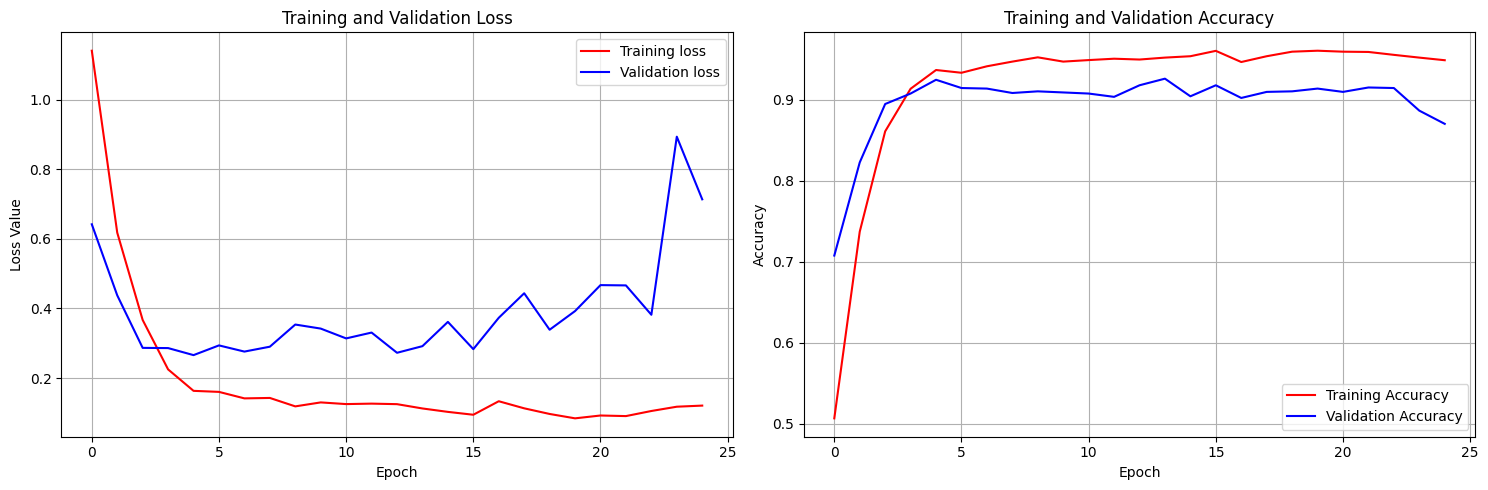

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

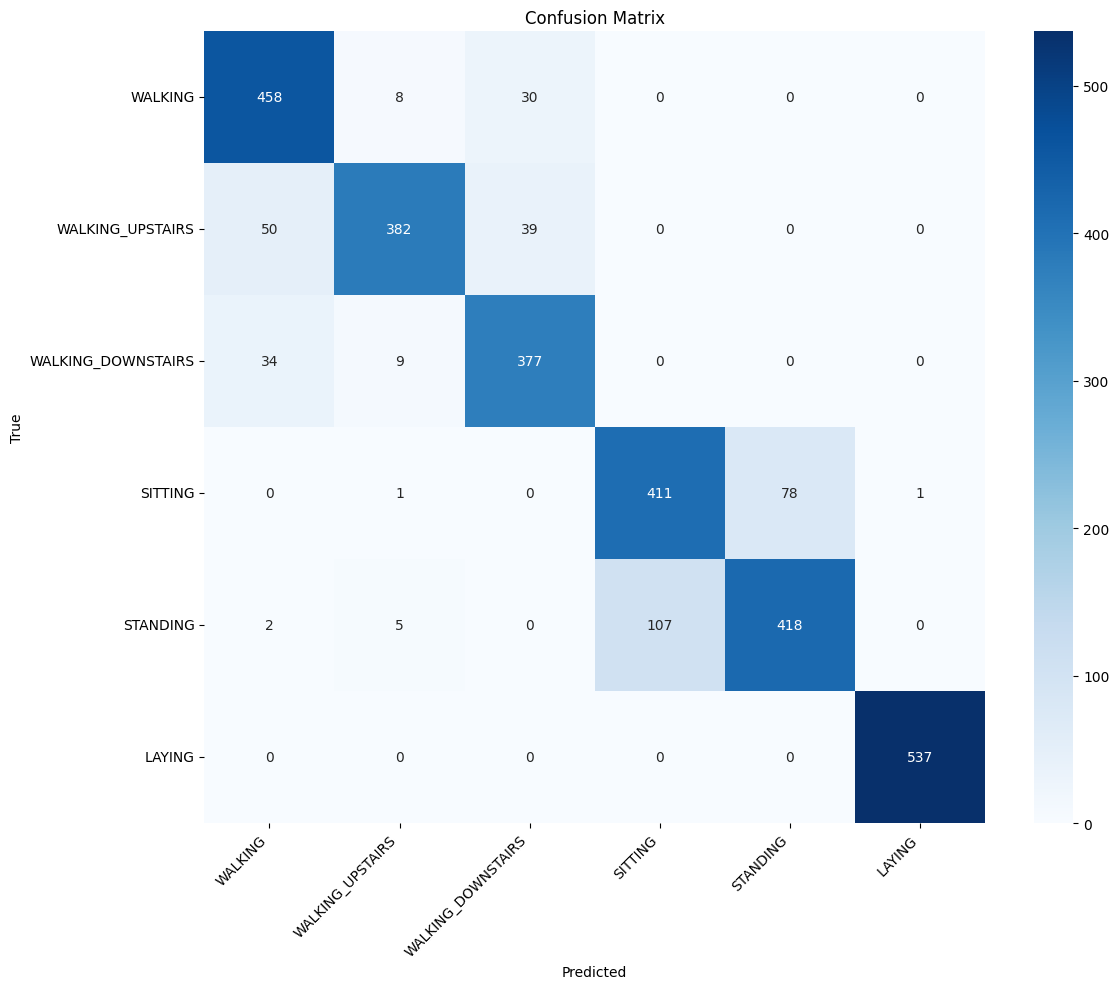

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()